# Graph Stochastic Attention (GSAT)
<a href="https://arxiv.org/abs/2201.12987"><img src="https://img.shields.io/badge/-Paper-grey?logo=gitbook&logoColor=white" alt="Paper"></a>
<a href="https://github.com/Graph-COM/GSAT"><img src="https://img.shields.io/badge/-Github-grey?logo=github" alt="Github"></a>
<a href="https://colab.research.google.com/drive/1t0_4BxEJ0XncyYvn_VyEQhxwNMvtSUNx?usp=sharing"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Colab"></a>
<a href="https://proceedings.mlr.press/v162/miao22a.html"> <img alt="License" src="https://img.shields.io/static/v1?label=Pub&message=ICML%2722&color=blue"> </a>

**Blog ([English](https://towardsdatascience.com/graph-machine-learning-icml-2022-252f39865c70#be75:~:text=and%20inductive%20settings.-,%E2%9E%A1%EF%B8%8F%20Miao%20et%20al,-take%20another%20perspective) - [中文](https://mp.weixin.qq.com/s/aP-XBqFLV0x8h9rtOKU_yg))** |
**[Slides](https://icml.cc/media/icml-2022/Slides/17430.pdf)** |
**[Poster](https://icml.cc/media/PosterPDFs/ICML%202022/a8acc28734d4fe90ea24353d901ae678.png)**

## Install dependencies

In [1]:
# Use the latest version of PyTorch and PyTorch-Geometric to skip re-install pytorch.
# The following installation is valid as of June 2022 with torch==1.11.0+cu113 and pyg==2.0.5.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

! pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
! pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
! pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# In case future versions of PyTorch or PyTorch-Geometric do not fit current code, use the following instead to install them, which may take a while.
# ! pip install torch==1.10.0+cu113 torchvision -f https://download.pytorch.org/whl/torch_stable.html
# ! pip install torch-scatter==2.0.9 torch-sparse==0.6.12 torch-cluster==1.5.9 torch-spline-conv==1.2.1 torch-geometric==2.0.3 -f https://data.pyg.org/whl/torch-1.10.0+cu113.html

In [2]:
! pip install ogb==1.3.2  # to download ogbg datasets
! pip install rdkit-pypi==2021.9.4  # to visualize molecular related datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Clone GSAT repository

In [3]:
! git clone https://github.com/Graph-COM/GSAT.git

fatal: destination path 'GSAT' already exists and is not an empty directory.


## Download datasets
1. The example in this Colab should support `Ba_2Motifs`, `Spurious-Motif`, `OGBG-Mol`, and `Mutag`.
  - Raw `Mutag` dataset need to download manually using the following code. And due to the RAM limit of Colab, we also provide processed `data.pt` file directly.
  - Other datasets can be downloaded automatically.
  - For `Spurious-Motif`, some hard-coded hyperparameters need to be changed accordingly, e.g. `learn_edge_att=True`. See `src/config` for more detail.

2. We do not provide Graph-SST2 and MNIST-75sp here, and please see https://github.com/Graph-COM/GSAT#instructions-on-acquiring-datasets for more details.




In [ ]:
# If one is interested in training on the Mutag dataset, download it via the following code.
! gdown --folder https://drive.google.com/drive/folders/1xcklnllvTZ6UdhlRtLDYfgYYnwOJN8im?usp=sharing -O ./GSAT/data/mutag/raw
! unzip ./GSAT/data/mutag/raw/\*.zip -d ./GSAT/data/mutag/raw/
! mkdir ./GSAT/data/mutag/processed
! mv ./GSAT/data/mutag/raw/data.pt ./GSAT/data/mutag/processed/data.pt 

Retrieving folder list
Processing file 1c9zHfPjaQ8gA78kRaTE89BgY2sZZiie1 data.pt
Processing file 10_kOaWVBjzCqX7vri5-p-Xno8DWPiFg5 Mutagenicity.pkl.zip
Processing file 1ha2ZG9RpHXZWAv_HwQRB4HJ1gYwZswhx Mutagenicity.zip
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1c9zHfPjaQ8gA78kRaTE89BgY2sZZiie1
To: /content/GSAT/data/mutag/raw/data.pt
100% 9.44M/9.44M [00:00<00:00, 79.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=10_kOaWVBjzCqX7vri5-p-Xno8DWPiFg5
To: /content/GSAT/data/mutag/raw/Mutagenicity.pkl.zip
100% 10.3M/10.3M [00:00<00:00, 198MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ha2ZG9RpHXZWAv_HwQRB4HJ1gYwZswhx
To: /content/GSAT/data/mutag/raw/Mutagenicity.zip
100% 927k/927k [00:00<00:00, 174MB/s]
Download completed
Archive:  ./GSAT/data/mutag/raw/Mutagenicity.zip
  inflating: ./GSAT/data/mutag/raw/Mutagenicity_A.txt  
  inflating: ./GSAT/data/mutag/raw

## Train GSAT

In [2]:
import os
os.chdir('./GSAT/example')

In [3]:
import sys
sys.path.append('../src')

import torch
import torch.nn as nn
from copy import deepcopy
from pathlib import Path
from gsat import GSAT, ExtractorMLP
from utils import get_data_loaders, get_model, set_seed, Criterion, init_metric_dict, load_checkpoint
from trainer import run_one_epoch, update_best_epoch_res, get_viz_idx, visualize_results
from datetime import datetime

In [11]:
# dataset_name = 'ba_2motifs'
dataset_name = 'ba_community' # ba_shapes, ba_community, tree_cycle, tree_grid
# dataset_name = 'mutag'
model_name = 'GIN'

# dataset_name = 'ogbg_molhiv'
# model_name = 'PNA'

method_name = 'GSAT'
cuda_id = 0  # set to -1 to use cpus
seed = 0
set_seed(seed)

In [12]:
data_dir = Path('../data')
device = torch.device(f'cuda:{cuda_id}' if cuda_id >= 0 else 'cpu')

if model_name == 'GIN':
    model_config = {'model_name': 'GIN', 'hidden_size': 64, 'n_layers': 2, 'dropout_p': 0.3, 'use_edge_attr': True}
else:
    assert model_name == 'PNA'
    model_config = {'model_name': 'PNA', 'hidden_size': 80, 'n_layers': 4, 'dropout_p': 0.3, 'use_edge_attr': False, 
                    'atom_encoder': True, 'aggregators': ['mean', 'min', 'max', 'std'], 'scalers': False}
    
metric_dict = deepcopy(init_metric_dict)
model_dir = data_dir / dataset_name / 'logs' / (datetime.now().strftime("%m_%d_%Y-%H_%M_%S") + '-' + dataset_name + '-' + model_name + '-seed' + str(seed) + '-' + method_name)

In [14]:
loaders, test_set, x_dim, edge_attr_dim, num_class, aux_info = get_data_loaders(data_dir, dataset_name, batch_size=128, random_state=seed,
                                                                                # splits={'train': 0.8, 'valid': 0.1, 'test': 0.1}, 
                                                                                splits={'train': 1, 'valid': 0, 'test': 0}, 
                                                                                mutag_x=True if dataset_name == 'mutag' else False)
model_config['deg'] = aux_info['deg']

[INFO] Randomly split dataset!


IndexError: ignored

In [10]:
clf = get_model(x_dim, edge_attr_dim, num_class, aux_info['multi_label'], model_config, device)
extractor = ExtractorMLP(model_config['hidden_size'], learn_edge_att=False).to(device)
optimizer = torch.optim.Adam(list(extractor.parameters()) + list(clf.parameters()), lr=1e-3, weight_decay=3.0e-6)
criterion = Criterion(num_class, aux_info['multi_label'])
gsat = GSAT(clf, extractor, criterion, optimizer, learn_edge_att=False, final_r=0.7)

[INFO] Using multi_label: False


In [11]:
for epoch in range(100):
    train_res = run_one_epoch(gsat, loaders['train'], epoch, 'train', dataset_name, seed, model_config['use_edge_attr'], aux_info['multi_label'])
    valid_res = run_one_epoch(gsat, loaders['valid'], epoch, 'valid', dataset_name, seed, model_config['use_edge_attr'], aux_info['multi_label'])
    test_res = run_one_epoch(gsat, loaders['test'], epoch, 'test', dataset_name, seed, model_config['use_edge_attr'], aux_info['multi_label'])
    
    metric_dict = update_best_epoch_res(gsat, train_res, valid_res, test_res, metric_dict, dataset_name, epoch, model_dir)
    print(f'[Seed {seed}, Epoch: {epoch}]: Best Epoch: {metric_dict["metric/best_clf_epoch"]}, '
          f'Best Val Pred ACC/ROC: {metric_dict["metric/best_clf_valid"]:.3f}, Best Test Pred ACC/ROC: {metric_dict["metric/best_clf_test"]:.3f}, '
          f'Best Test X AUROC: {metric_dict["metric/best_x_roc_test"]:.3f}')
    print('='*50)
    print('='*50)

[Seed 0, Epoch: 0]: gsat_train finished, loss: 1.612, pred: 1.003, info: 0.609, clf_acc: 0.517, clf_roc: 0.000, att_roc: 0.457: 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]
[Seed 0, Epoch: 0]: gsat_valid finished, loss: 1.013, pred: 0.696, info: 0.317, clf_acc: 0.450, clf_roc: 0.000, att_roc: 0.185: 100%|██████████| 1/1 [00:00<00:00, 41.36it/s]
[Seed 0, Epoch: 0]: gsat_test  finished, loss: 1.014, pred: 0.698, info: 0.317, clf_acc: 0.390, clf_roc: 0.000, att_roc: 0.240: 100%|██████████| 1/1 [00:00<00:00, 38.97it/s]


[Seed 0, Epoch: 0]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 1]: gsat_train finished, loss: 1.375, pred: 0.829, info: 0.546, clf_acc: 0.514, clf_roc: 0.000, att_roc: 0.461: 100%|██████████| 7/7 [00:00<00:00, 36.05it/s]
[Seed 0, Epoch: 1]: gsat_valid finished, loss: 0.943, pred: 0.690, info: 0.253, clf_acc: 0.560, clf_roc: 0.000, att_roc: 0.392: 100%|██████████| 1/1 [00:00<00:00, 73.86it/s]
[Seed 0, Epoch: 1]: gsat_test  finished, loss: 0.939, pred: 0.687, info: 0.252, clf_acc: 0.520, clf_roc: 0.000, att_roc: 0.396: 100%|██████████| 1/1 [00:00<00:00, 60.35it/s]


[Seed 0, Epoch: 1]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 2]: gsat_train finished, loss: 1.324, pred: 0.825, info: 0.499, clf_acc: 0.490, clf_roc: 0.000, att_roc: 0.465: 100%|██████████| 7/7 [00:00<00:00, 37.84it/s]
[Seed 0, Epoch: 2]: gsat_valid finished, loss: 0.899, pred: 0.707, info: 0.192, clf_acc: 0.460, clf_roc: 0.000, att_roc: 0.199: 100%|██████████| 1/1 [00:00<00:00, 67.52it/s]
[Seed 0, Epoch: 2]: gsat_test  finished, loss: 0.881, pred: 0.692, info: 0.190, clf_acc: 0.540, clf_roc: 0.000, att_roc: 0.186: 100%|██████████| 1/1 [00:00<00:00, 63.58it/s]


[Seed 0, Epoch: 2]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 3]: gsat_train finished, loss: 1.291, pred: 0.839, info: 0.452, clf_acc: 0.469, clf_roc: 0.000, att_roc: 0.449: 100%|██████████| 7/7 [00:00<00:00, 41.47it/s]
[Seed 0, Epoch: 3]: gsat_valid finished, loss: 0.859, pred: 0.710, info: 0.149, clf_acc: 0.550, clf_roc: 0.000, att_roc: 0.525: 100%|██████████| 1/1 [00:00<00:00, 60.89it/s]
[Seed 0, Epoch: 3]: gsat_test  finished, loss: 0.911, pred: 0.762, info: 0.149, clf_acc: 0.460, clf_roc: 0.000, att_roc: 0.486: 100%|██████████| 1/1 [00:00<00:00, 64.77it/s]


[Seed 0, Epoch: 3]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 4]: gsat_train finished, loss: 1.194, pred: 0.780, info: 0.414, clf_acc: 0.491, clf_roc: 0.000, att_roc: 0.472: 100%|██████████| 7/7 [00:00<00:00, 41.66it/s]
[Seed 0, Epoch: 4]: gsat_valid finished, loss: 0.805, pred: 0.679, info: 0.126, clf_acc: 0.550, clf_roc: 0.000, att_roc: 0.734: 100%|██████████| 1/1 [00:00<00:00, 43.19it/s]
[Seed 0, Epoch: 4]: gsat_test  finished, loss: 0.831, pred: 0.705, info: 0.126, clf_acc: 0.470, clf_roc: 0.000, att_roc: 0.682: 100%|██████████| 1/1 [00:00<00:00, 52.28it/s]


[Seed 0, Epoch: 4]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 5]: gsat_train finished, loss: 1.120, pred: 0.741, info: 0.379, clf_acc: 0.544, clf_roc: 0.000, att_roc: 0.477: 100%|██████████| 7/7 [00:00<00:00, 37.10it/s]
[Seed 0, Epoch: 5]: gsat_valid finished, loss: 0.763, pred: 0.678, info: 0.085, clf_acc: 0.530, clf_roc: 0.000, att_roc: 0.761: 100%|██████████| 1/1 [00:00<00:00, 71.24it/s]
[Seed 0, Epoch: 5]: gsat_test  finished, loss: 0.788, pred: 0.704, info: 0.084, clf_acc: 0.470, clf_roc: 0.000, att_roc: 0.709: 100%|██████████| 1/1 [00:00<00:00, 51.89it/s]


[Seed 0, Epoch: 5]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 6]: gsat_train finished, loss: 1.090, pred: 0.748, info: 0.342, clf_acc: 0.502, clf_roc: 0.000, att_roc: 0.498: 100%|██████████| 7/7 [00:00<00:00, 37.40it/s]
[Seed 0, Epoch: 6]: gsat_valid finished, loss: 0.734, pred: 0.668, info: 0.066, clf_acc: 0.700, clf_roc: 0.000, att_roc: 0.874: 100%|██████████| 1/1 [00:00<00:00, 62.13it/s]
[Seed 0, Epoch: 6]: gsat_test  finished, loss: 0.751, pred: 0.686, info: 0.065, clf_acc: 0.590, clf_roc: 0.000, att_roc: 0.845: 100%|██████████| 1/1 [00:00<00:00, 61.70it/s]


[Seed 0, Epoch: 6]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 7]: gsat_train finished, loss: 1.022, pred: 0.713, info: 0.309, clf_acc: 0.541, clf_roc: 0.000, att_roc: 0.487: 100%|██████████| 7/7 [00:00<00:00, 35.60it/s]
[Seed 0, Epoch: 7]: gsat_valid finished, loss: 0.717, pred: 0.676, info: 0.041, clf_acc: 0.550, clf_roc: 0.000, att_roc: 0.799: 100%|██████████| 1/1 [00:00<00:00, 62.13it/s]
[Seed 0, Epoch: 7]: gsat_test  finished, loss: 0.745, pred: 0.704, info: 0.041, clf_acc: 0.490, clf_roc: 0.000, att_roc: 0.772: 100%|██████████| 1/1 [00:00<00:00, 42.70it/s]


[Seed 0, Epoch: 7]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 8]: gsat_train finished, loss: 0.994, pred: 0.712, info: 0.283, clf_acc: 0.555, clf_roc: 0.000, att_roc: 0.497: 100%|██████████| 7/7 [00:00<00:00, 39.35it/s]
[Seed 0, Epoch: 8]: gsat_valid finished, loss: 0.687, pred: 0.659, info: 0.028, clf_acc: 0.640, clf_roc: 0.000, att_roc: 0.871: 100%|██████████| 1/1 [00:00<00:00, 53.47it/s]
[Seed 0, Epoch: 8]: gsat_test  finished, loss: 0.712, pred: 0.684, info: 0.028, clf_acc: 0.530, clf_roc: 0.000, att_roc: 0.861: 100%|██████████| 1/1 [00:00<00:00, 50.26it/s]


[Seed 0, Epoch: 8]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 9]: gsat_train finished, loss: 0.965, pred: 0.706, info: 0.259, clf_acc: 0.559, clf_roc: 0.000, att_roc: 0.514: 100%|██████████| 7/7 [00:00<00:00, 37.59it/s]
[Seed 0, Epoch: 9]: gsat_valid finished, loss: 0.682, pred: 0.667, info: 0.016, clf_acc: 0.550, clf_roc: 0.000, att_roc: 0.699: 100%|██████████| 1/1 [00:00<00:00, 62.91it/s]
[Seed 0, Epoch: 9]: gsat_test  finished, loss: 0.711, pred: 0.695, info: 0.016, clf_acc: 0.470, clf_roc: 0.000, att_roc: 0.673: 100%|██████████| 1/1 [00:00<00:00, 65.09it/s]


[Seed 0, Epoch: 9]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 10]: gsat_train finished, loss: 0.831, pred: 0.660, info: 0.171, clf_acc: 0.578, clf_roc: 0.000, att_roc: 0.540: 100%|██████████| 7/7 [00:00<00:00, 37.77it/s]
[Seed 0, Epoch: 10]: gsat_valid finished, loss: 0.675, pred: 0.652, info: 0.024, clf_acc: 0.650, clf_roc: 0.000, att_roc: 0.877: 100%|██████████| 1/1 [00:00<00:00, 56.83it/s]
[Seed 0, Epoch: 10]: gsat_test  finished, loss: 0.679, pred: 0.655, info: 0.024, clf_acc: 0.620, clf_roc: 0.000, att_roc: 0.842: 100%|██████████| 1/1 [00:00<00:00, 64.03it/s]


[Seed 0, Epoch: 10]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 11]: gsat_train finished, loss: 0.854, pred: 0.689, info: 0.165, clf_acc: 0.576, clf_roc: 0.000, att_roc: 0.560: 100%|██████████| 7/7 [00:00<00:00, 39.30it/s]
[Seed 0, Epoch: 11]: gsat_valid finished, loss: 0.643, pred: 0.611, info: 0.032, clf_acc: 0.570, clf_roc: 0.000, att_roc: 0.976: 100%|██████████| 1/1 [00:00<00:00, 53.62it/s]
[Seed 0, Epoch: 11]: gsat_test  finished, loss: 0.682, pred: 0.649, info: 0.032, clf_acc: 0.520, clf_roc: 0.000, att_roc: 0.974: 100%|██████████| 1/1 [00:00<00:00, 44.80it/s]


[Seed 0, Epoch: 11]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 12]: gsat_train finished, loss: 0.834, pred: 0.671, info: 0.163, clf_acc: 0.591, clf_roc: 0.000, att_roc: 0.580: 100%|██████████| 7/7 [00:00<00:00, 41.24it/s]
[Seed 0, Epoch: 12]: gsat_valid finished, loss: 0.609, pred: 0.569, info: 0.041, clf_acc: 0.900, clf_roc: 0.000, att_roc: 0.984: 100%|██████████| 1/1 [00:00<00:00, 52.86it/s]
[Seed 0, Epoch: 12]: gsat_test  finished, loss: 0.648, pred: 0.607, info: 0.041, clf_acc: 0.820, clf_roc: 0.000, att_roc: 0.984: 100%|██████████| 1/1 [00:00<00:00, 53.10it/s]


[Seed 0, Epoch: 12]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 13]: gsat_train finished, loss: 0.788, pred: 0.626, info: 0.161, clf_acc: 0.623, clf_roc: 0.000, att_roc: 0.635: 100%|██████████| 7/7 [00:00<00:00, 39.17it/s]
[Seed 0, Epoch: 13]: gsat_valid finished, loss: 0.609, pred: 0.552, info: 0.057, clf_acc: 0.850, clf_roc: 0.000, att_roc: 0.984: 100%|██████████| 1/1 [00:00<00:00, 67.67it/s]
[Seed 0, Epoch: 13]: gsat_test  finished, loss: 0.625, pred: 0.568, info: 0.057, clf_acc: 0.810, clf_roc: 0.000, att_roc: 0.986: 100%|██████████| 1/1 [00:00<00:00, 50.90it/s]


[Seed 0, Epoch: 13]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 14]: gsat_train finished, loss: 0.771, pred: 0.607, info: 0.165, clf_acc: 0.691, clf_roc: 0.000, att_roc: 0.682: 100%|██████████| 7/7 [00:00<00:00, 36.71it/s]
[Seed 0, Epoch: 14]: gsat_valid finished, loss: 0.605, pred: 0.538, info: 0.067, clf_acc: 0.670, clf_roc: 0.000, att_roc: 0.989: 100%|██████████| 1/1 [00:00<00:00, 52.86it/s]
[Seed 0, Epoch: 14]: gsat_test  finished, loss: 0.610, pred: 0.543, info: 0.067, clf_acc: 0.640, clf_roc: 0.000, att_roc: 0.990: 100%|██████████| 1/1 [00:00<00:00, 57.00it/s]


[Seed 0, Epoch: 14]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 15]: gsat_train finished, loss: 0.733, pred: 0.568, info: 0.165, clf_acc: 0.723, clf_roc: 0.000, att_roc: 0.712: 100%|██████████| 7/7 [00:00<00:00, 37.96it/s]
[Seed 0, Epoch: 15]: gsat_valid finished, loss: 0.563, pred: 0.492, info: 0.071, clf_acc: 0.830, clf_roc: 0.000, att_roc: 0.990: 100%|██████████| 1/1 [00:00<00:00, 59.20it/s]
[Seed 0, Epoch: 15]: gsat_test  finished, loss: 0.571, pred: 0.500, info: 0.071, clf_acc: 0.780, clf_roc: 0.000, att_roc: 0.992: 100%|██████████| 1/1 [00:00<00:00, 60.55it/s]


[Seed 0, Epoch: 15]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 16]: gsat_train finished, loss: 0.716, pred: 0.547, info: 0.168, clf_acc: 0.748, clf_roc: 0.000, att_roc: 0.757: 100%|██████████| 7/7 [00:00<00:00, 38.63it/s]
[Seed 0, Epoch: 16]: gsat_valid finished, loss: 0.567, pred: 0.482, info: 0.085, clf_acc: 0.720, clf_roc: 0.000, att_roc: 0.988: 100%|██████████| 1/1 [00:00<00:00, 71.55it/s]
[Seed 0, Epoch: 16]: gsat_test  finished, loss: 0.565, pred: 0.481, info: 0.084, clf_acc: 0.660, clf_roc: 0.000, att_roc: 0.991: 100%|██████████| 1/1 [00:00<00:00, 45.22it/s]


[Seed 0, Epoch: 16]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 17]: gsat_train finished, loss: 0.674, pred: 0.499, info: 0.175, clf_acc: 0.764, clf_roc: 0.000, att_roc: 0.790: 100%|██████████| 7/7 [00:00<00:00, 36.42it/s]
[Seed 0, Epoch: 17]: gsat_valid finished, loss: 0.498, pred: 0.400, info: 0.097, clf_acc: 0.940, clf_roc: 0.000, att_roc: 0.983: 100%|██████████| 1/1 [00:00<00:00, 53.90it/s]
[Seed 0, Epoch: 17]: gsat_test  finished, loss: 0.507, pred: 0.410, info: 0.097, clf_acc: 0.920, clf_roc: 0.000, att_roc: 0.987: 100%|██████████| 1/1 [00:00<00:00, 51.73it/s]


[Seed 0, Epoch: 17]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 18]: gsat_train finished, loss: 0.680, pred: 0.500, info: 0.179, clf_acc: 0.781, clf_roc: 0.000, att_roc: 0.805: 100%|██████████| 7/7 [00:00<00:00, 39.76it/s]
[Seed 0, Epoch: 18]: gsat_valid finished, loss: 0.501, pred: 0.397, info: 0.104, clf_acc: 0.920, clf_roc: 0.000, att_roc: 0.977: 100%|██████████| 1/1 [00:00<00:00, 57.79it/s]
[Seed 0, Epoch: 18]: gsat_test  finished, loss: 0.516, pred: 0.412, info: 0.104, clf_acc: 0.900, clf_roc: 0.000, att_roc: 0.982: 100%|██████████| 1/1 [00:00<00:00, 53.13it/s]


[Seed 0, Epoch: 18]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 19]: gsat_train finished, loss: 0.618, pred: 0.436, info: 0.182, clf_acc: 0.836, clf_roc: 0.000, att_roc: 0.819: 100%|██████████| 7/7 [00:00<00:00, 36.73it/s]
[Seed 0, Epoch: 19]: gsat_valid finished, loss: 0.397, pred: 0.313, info: 0.084, clf_acc: 0.990, clf_roc: 0.000, att_roc: 0.983: 100%|██████████| 1/1 [00:00<00:00, 55.29it/s]
[Seed 0, Epoch: 19]: gsat_test  finished, loss: 0.439, pred: 0.356, info: 0.083, clf_acc: 0.980, clf_roc: 0.000, att_roc: 0.987: 100%|██████████| 1/1 [00:00<00:00, 56.46it/s]


[Seed 0, Epoch: 19]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 20]: gsat_train finished, loss: 0.608, pred: 0.400, info: 0.207, clf_acc: 0.843, clf_roc: 0.000, att_roc: 0.812: 100%|██████████| 7/7 [00:00<00:00, 40.18it/s]
[Seed 0, Epoch: 20]: gsat_valid finished, loss: 0.436, pred: 0.304, info: 0.131, clf_acc: 1.000, clf_roc: 0.000, att_roc: 0.986: 100%|██████████| 1/1 [00:00<00:00, 68.66it/s]
[Seed 0, Epoch: 20]: gsat_test  finished, loss: 0.480, pred: 0.349, info: 0.131, clf_acc: 0.960, clf_roc: 0.000, att_roc: 0.990: 100%|██████████| 1/1 [00:00<00:00, 48.59it/s]


[Seed 0, Epoch: 20]: Best Epoch: 20, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.960, Best Test X AUROC: 0.990


[Seed 0, Epoch: 21]: gsat_train finished, loss: 0.576, pred: 0.364, info: 0.212, clf_acc: 0.863, clf_roc: 0.000, att_roc: 0.880: 100%|██████████| 7/7 [00:00<00:00, 39.96it/s]
[Seed 0, Epoch: 21]: gsat_valid finished, loss: 0.430, pred: 0.303, info: 0.128, clf_acc: 0.970, clf_roc: 0.000, att_roc: 0.984: 100%|██████████| 1/1 [00:00<00:00, 48.85it/s]
[Seed 0, Epoch: 21]: gsat_test  finished, loss: 0.482, pred: 0.355, info: 0.127, clf_acc: 0.950, clf_roc: 0.000, att_roc: 0.987: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s]


[Seed 0, Epoch: 21]: Best Epoch: 20, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.960, Best Test X AUROC: 0.990


[Seed 0, Epoch: 22]: gsat_train finished, loss: 0.541, pred: 0.330, info: 0.211, clf_acc: 0.877, clf_roc: 0.000, att_roc: 0.872: 100%|██████████| 7/7 [00:00<00:00, 37.87it/s]
[Seed 0, Epoch: 22]: gsat_valid finished, loss: 0.396, pred: 0.267, info: 0.129, clf_acc: 0.980, clf_roc: 0.000, att_roc: 0.981: 100%|██████████| 1/1 [00:00<00:00, 52.52it/s]
[Seed 0, Epoch: 22]: gsat_test  finished, loss: 0.445, pred: 0.317, info: 0.128, clf_acc: 0.960, clf_roc: 0.000, att_roc: 0.985: 100%|██████████| 1/1 [00:00<00:00, 57.83it/s]


[Seed 0, Epoch: 22]: Best Epoch: 20, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.960, Best Test X AUROC: 0.990


[Seed 0, Epoch: 23]: gsat_train finished, loss: 0.520, pred: 0.308, info: 0.212, clf_acc: 0.885, clf_roc: 0.000, att_roc: 0.882: 100%|██████████| 7/7 [00:00<00:00, 40.07it/s]
[Seed 0, Epoch: 23]: gsat_valid finished, loss: 0.377, pred: 0.272, info: 0.105, clf_acc: 1.000, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 54.76it/s]
[Seed 0, Epoch: 23]: gsat_test  finished, loss: 0.410, pred: 0.305, info: 0.105, clf_acc: 0.960, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 41.84it/s]


[Seed 0, Epoch: 23]: Best Epoch: 23, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.960, Best Test X AUROC: 0.995


[Seed 0, Epoch: 24]: gsat_train finished, loss: 0.535, pred: 0.317, info: 0.218, clf_acc: 0.899, clf_roc: 0.000, att_roc: 0.903: 100%|██████████| 7/7 [00:00<00:00, 40.98it/s]
[Seed 0, Epoch: 24]: gsat_valid finished, loss: 0.451, pred: 0.328, info: 0.124, clf_acc: 0.840, clf_roc: 0.000, att_roc: 0.987: 100%|██████████| 1/1 [00:00<00:00, 65.34it/s]
[Seed 0, Epoch: 24]: gsat_test  finished, loss: 0.524, pred: 0.401, info: 0.123, clf_acc: 0.800, clf_roc: 0.000, att_roc: 0.989: 100%|██████████| 1/1 [00:00<00:00, 61.93it/s]


[Seed 0, Epoch: 24]: Best Epoch: 23, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.960, Best Test X AUROC: 0.995


[Seed 0, Epoch: 25]: gsat_train finished, loss: 0.489, pred: 0.273, info: 0.217, clf_acc: 0.899, clf_roc: 0.000, att_roc: 0.891: 100%|██████████| 7/7 [00:00<00:00, 37.33it/s]
[Seed 0, Epoch: 25]: gsat_valid finished, loss: 0.342, pred: 0.240, info: 0.103, clf_acc: 0.990, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 62.18it/s]
[Seed 0, Epoch: 25]: gsat_test  finished, loss: 0.387, pred: 0.284, info: 0.103, clf_acc: 0.970, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 62.51it/s]


[Seed 0, Epoch: 25]: Best Epoch: 23, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.960, Best Test X AUROC: 0.995


[Seed 0, Epoch: 26]: gsat_train finished, loss: 0.477, pred: 0.256, info: 0.222, clf_acc: 0.916, clf_roc: 0.000, att_roc: 0.941: 100%|██████████| 7/7 [00:00<00:00, 39.78it/s]
[Seed 0, Epoch: 26]: gsat_valid finished, loss: 0.325, pred: 0.215, info: 0.110, clf_acc: 1.000, clf_roc: 0.000, att_roc: 0.991: 100%|██████████| 1/1 [00:00<00:00, 52.28it/s]
[Seed 0, Epoch: 26]: gsat_test  finished, loss: 0.378, pred: 0.267, info: 0.110, clf_acc: 0.950, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 60.31it/s]


[Seed 0, Epoch: 26]: Best Epoch: 26, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.950, Best Test X AUROC: 0.993


[Seed 0, Epoch: 27]: gsat_train finished, loss: 0.466, pred: 0.248, info: 0.218, clf_acc: 0.921, clf_roc: 0.000, att_roc: 0.902: 100%|██████████| 7/7 [00:00<00:00, 40.71it/s]
[Seed 0, Epoch: 27]: gsat_valid finished, loss: 0.358, pred: 0.252, info: 0.106, clf_acc: 0.990, clf_roc: 0.000, att_roc: 0.988: 100%|██████████| 1/1 [00:00<00:00, 60.58it/s]
[Seed 0, Epoch: 27]: gsat_test  finished, loss: 0.409, pred: 0.304, info: 0.105, clf_acc: 0.930, clf_roc: 0.000, att_roc: 0.991: 100%|██████████| 1/1 [00:00<00:00, 35.62it/s]


[Seed 0, Epoch: 27]: Best Epoch: 26, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.950, Best Test X AUROC: 0.993


[Seed 0, Epoch: 28]: gsat_train finished, loss: 0.418, pred: 0.199, info: 0.219, clf_acc: 0.939, clf_roc: 0.000, att_roc: 0.925: 100%|██████████| 7/7 [00:00<00:00, 39.85it/s]
[Seed 0, Epoch: 28]: gsat_valid finished, loss: 0.401, pred: 0.296, info: 0.106, clf_acc: 0.980, clf_roc: 0.000, att_roc: 0.986: 100%|██████████| 1/1 [00:00<00:00, 60.06it/s]
[Seed 0, Epoch: 28]: gsat_test  finished, loss: 0.445, pred: 0.340, info: 0.104, clf_acc: 0.920, clf_roc: 0.000, att_roc: 0.990: 100%|██████████| 1/1 [00:00<00:00, 37.30it/s]


[Seed 0, Epoch: 28]: Best Epoch: 26, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.950, Best Test X AUROC: 0.993


[Seed 0, Epoch: 29]: gsat_train finished, loss: 0.421, pred: 0.201, info: 0.220, clf_acc: 0.935, clf_roc: 0.000, att_roc: 0.928: 100%|██████████| 7/7 [00:00<00:00, 38.80it/s]
[Seed 0, Epoch: 29]: gsat_valid finished, loss: 1.589, pred: 1.480, info: 0.108, clf_acc: 0.460, clf_roc: 0.000, att_roc: 0.985: 100%|██████████| 1/1 [00:00<00:00, 52.82it/s]
[Seed 0, Epoch: 29]: gsat_test  finished, loss: 1.468, pred: 1.363, info: 0.106, clf_acc: 0.530, clf_roc: 0.000, att_roc: 0.988: 100%|██████████| 1/1 [00:00<00:00, 48.56it/s]


[Seed 0, Epoch: 29]: Best Epoch: 26, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.950, Best Test X AUROC: 0.993


[Seed 0, Epoch: 30]: gsat_train finished, loss: 0.410, pred: 0.190, info: 0.220, clf_acc: 0.940, clf_roc: 0.000, att_roc: 0.947: 100%|██████████| 7/7 [00:00<00:00, 39.08it/s]
[Seed 0, Epoch: 30]: gsat_valid finished, loss: 0.374, pred: 0.264, info: 0.110, clf_acc: 0.920, clf_roc: 0.000, att_roc: 0.988: 100%|██████████| 1/1 [00:00<00:00, 58.46it/s]
[Seed 0, Epoch: 30]: gsat_test  finished, loss: 0.424, pred: 0.315, info: 0.109, clf_acc: 0.900, clf_roc: 0.000, att_roc: 0.991: 100%|██████████| 1/1 [00:00<00:00, 44.75it/s]


[Seed 0, Epoch: 30]: Best Epoch: 26, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.950, Best Test X AUROC: 0.993


[Seed 0, Epoch: 31]: gsat_train finished, loss: 0.385, pred: 0.162, info: 0.222, clf_acc: 0.939, clf_roc: 0.000, att_roc: 0.912: 100%|██████████| 7/7 [00:00<00:00, 38.43it/s]
[Seed 0, Epoch: 31]: gsat_valid finished, loss: 0.402, pred: 0.289, info: 0.113, clf_acc: 0.870, clf_roc: 0.000, att_roc: 0.990: 100%|██████████| 1/1 [00:00<00:00, 61.77it/s]
[Seed 0, Epoch: 31]: gsat_test  finished, loss: 0.483, pred: 0.371, info: 0.112, clf_acc: 0.840, clf_roc: 0.000, att_roc: 0.992: 100%|██████████| 1/1 [00:00<00:00, 64.24it/s]


[Seed 0, Epoch: 31]: Best Epoch: 26, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.950, Best Test X AUROC: 0.993


[Seed 0, Epoch: 32]: gsat_train finished, loss: 0.436, pred: 0.213, info: 0.222, clf_acc: 0.940, clf_roc: 0.000, att_roc: 0.955: 100%|██████████| 7/7 [00:00<00:00, 39.83it/s]
[Seed 0, Epoch: 32]: gsat_valid finished, loss: 0.322, pred: 0.205, info: 0.117, clf_acc: 0.990, clf_roc: 0.000, att_roc: 0.990: 100%|██████████| 1/1 [00:00<00:00, 47.19it/s]
[Seed 0, Epoch: 32]: gsat_test  finished, loss: 0.386, pred: 0.269, info: 0.117, clf_acc: 0.940, clf_roc: 0.000, att_roc: 0.992: 100%|██████████| 1/1 [00:00<00:00, 53.51it/s]


[Seed 0, Epoch: 32]: Best Epoch: 26, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.950, Best Test X AUROC: 0.993


[Seed 0, Epoch: 33]: gsat_train finished, loss: 0.351, pred: 0.130, info: 0.221, clf_acc: 0.963, clf_roc: 0.000, att_roc: 0.946: 100%|██████████| 7/7 [00:00<00:00, 37.61it/s]
[Seed 0, Epoch: 33]: gsat_valid finished, loss: 0.257, pred: 0.152, info: 0.106, clf_acc: 0.990, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 63.63it/s]
[Seed 0, Epoch: 33]: gsat_test  finished, loss: 0.311, pred: 0.205, info: 0.106, clf_acc: 0.960, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 46.95it/s]


[Seed 0, Epoch: 33]: Best Epoch: 26, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.950, Best Test X AUROC: 0.993


[Seed 0, Epoch: 34]: gsat_train finished, loss: 0.371, pred: 0.147, info: 0.224, clf_acc: 0.954, clf_roc: 0.000, att_roc: 0.955: 100%|██████████| 7/7 [00:00<00:00, 39.25it/s]
[Seed 0, Epoch: 34]: gsat_valid finished, loss: 0.337, pred: 0.228, info: 0.108, clf_acc: 0.920, clf_roc: 0.000, att_roc: 0.991: 100%|██████████| 1/1 [00:00<00:00, 53.41it/s]
[Seed 0, Epoch: 34]: gsat_test  finished, loss: 0.390, pred: 0.282, info: 0.109, clf_acc: 0.920, clf_roc: 0.000, att_roc: 0.992: 100%|██████████| 1/1 [00:00<00:00, 46.01it/s]


[Seed 0, Epoch: 34]: Best Epoch: 26, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.950, Best Test X AUROC: 0.993


[Seed 0, Epoch: 35]: gsat_train finished, loss: 0.341, pred: 0.119, info: 0.222, clf_acc: 0.968, clf_roc: 0.000, att_roc: 0.963: 100%|██████████| 7/7 [00:00<00:00, 40.34it/s]
[Seed 0, Epoch: 35]: gsat_valid finished, loss: 0.579, pred: 0.465, info: 0.114, clf_acc: 0.690, clf_roc: 0.000, att_roc: 0.984: 100%|██████████| 1/1 [00:00<00:00, 70.54it/s]
[Seed 0, Epoch: 35]: gsat_test  finished, loss: 0.647, pred: 0.533, info: 0.114, clf_acc: 0.650, clf_roc: 0.000, att_roc: 0.987: 100%|██████████| 1/1 [00:00<00:00, 65.98it/s]


[Seed 0, Epoch: 35]: Best Epoch: 26, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.950, Best Test X AUROC: 0.993


[Seed 0, Epoch: 36]: gsat_train finished, loss: 0.351, pred: 0.127, info: 0.224, clf_acc: 0.969, clf_roc: 0.000, att_roc: 0.968: 100%|██████████| 7/7 [00:00<00:00, 39.40it/s]
[Seed 0, Epoch: 36]: gsat_valid finished, loss: 0.573, pred: 0.463, info: 0.110, clf_acc: 0.700, clf_roc: 0.000, att_roc: 0.990: 100%|██████████| 1/1 [00:00<00:00, 60.03it/s]
[Seed 0, Epoch: 36]: gsat_test  finished, loss: 0.661, pred: 0.551, info: 0.110, clf_acc: 0.670, clf_roc: 0.000, att_roc: 0.991: 100%|██████████| 1/1 [00:00<00:00, 55.16it/s]


[Seed 0, Epoch: 36]: Best Epoch: 26, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.950, Best Test X AUROC: 0.993


[Seed 0, Epoch: 37]: gsat_train finished, loss: 0.362, pred: 0.141, info: 0.221, clf_acc: 0.958, clf_roc: 0.000, att_roc: 0.966: 100%|██████████| 7/7 [00:00<00:00, 40.10it/s]
[Seed 0, Epoch: 37]: gsat_valid finished, loss: 0.265, pred: 0.160, info: 0.105, clf_acc: 1.000, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 60.43it/s]
[Seed 0, Epoch: 37]: gsat_test  finished, loss: 0.316, pred: 0.211, info: 0.105, clf_acc: 0.970, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 70.28it/s]


[Seed 0, Epoch: 37]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 38]: gsat_train finished, loss: 0.347, pred: 0.125, info: 0.222, clf_acc: 0.959, clf_roc: 0.000, att_roc: 0.963: 100%|██████████| 7/7 [00:00<00:00, 38.44it/s]
[Seed 0, Epoch: 38]: gsat_valid finished, loss: 0.281, pred: 0.172, info: 0.109, clf_acc: 0.990, clf_roc: 0.000, att_roc: 0.990: 100%|██████████| 1/1 [00:00<00:00, 47.10it/s]
[Seed 0, Epoch: 38]: gsat_test  finished, loss: 0.333, pred: 0.224, info: 0.109, clf_acc: 0.980, clf_roc: 0.000, att_roc: 0.992: 100%|██████████| 1/1 [00:00<00:00, 53.34it/s]


[Seed 0, Epoch: 38]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 39]: gsat_train finished, loss: 0.334, pred: 0.112, info: 0.221, clf_acc: 0.968, clf_roc: 0.000, att_roc: 0.947: 100%|██████████| 7/7 [00:00<00:00, 39.43it/s]
[Seed 0, Epoch: 39]: gsat_valid finished, loss: 0.244, pred: 0.140, info: 0.104, clf_acc: 0.990, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 60.14it/s]
[Seed 0, Epoch: 39]: gsat_test  finished, loss: 0.287, pred: 0.183, info: 0.103, clf_acc: 0.970, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 58.09it/s]


[Seed 0, Epoch: 39]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 40]: gsat_train finished, loss: 0.365, pred: 0.143, info: 0.223, clf_acc: 0.953, clf_roc: 0.000, att_roc: 0.969: 100%|██████████| 7/7 [00:00<00:00, 37.45it/s]
[Seed 0, Epoch: 40]: gsat_valid finished, loss: 0.608, pred: 0.489, info: 0.118, clf_acc: 0.710, clf_roc: 0.000, att_roc: 0.980: 100%|██████████| 1/1 [00:00<00:00, 66.08it/s]
[Seed 0, Epoch: 40]: gsat_test  finished, loss: 0.693, pred: 0.575, info: 0.118, clf_acc: 0.660, clf_roc: 0.000, att_roc: 0.983: 100%|██████████| 1/1 [00:00<00:00, 62.01it/s]


[Seed 0, Epoch: 40]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 41]: gsat_train finished, loss: 0.348, pred: 0.128, info: 0.221, clf_acc: 0.960, clf_roc: 0.000, att_roc: 0.949: 100%|██████████| 7/7 [00:00<00:00, 37.36it/s]
[Seed 0, Epoch: 41]: gsat_valid finished, loss: 0.339, pred: 0.231, info: 0.108, clf_acc: 0.920, clf_roc: 0.000, att_roc: 0.989: 100%|██████████| 1/1 [00:00<00:00, 58.95it/s]
[Seed 0, Epoch: 41]: gsat_test  finished, loss: 0.405, pred: 0.297, info: 0.108, clf_acc: 0.890, clf_roc: 0.000, att_roc: 0.991: 100%|██████████| 1/1 [00:00<00:00, 51.69it/s]


[Seed 0, Epoch: 41]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 42]: gsat_train finished, loss: 0.347, pred: 0.125, info: 0.222, clf_acc: 0.961, clf_roc: 0.000, att_roc: 0.974: 100%|██████████| 7/7 [00:00<00:00, 39.16it/s]
[Seed 0, Epoch: 42]: gsat_valid finished, loss: 0.504, pred: 0.393, info: 0.111, clf_acc: 0.770, clf_roc: 0.000, att_roc: 0.992: 100%|██████████| 1/1 [00:00<00:00, 45.64it/s]
[Seed 0, Epoch: 42]: gsat_test  finished, loss: 0.609, pred: 0.498, info: 0.111, clf_acc: 0.730, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 50.87it/s]


[Seed 0, Epoch: 42]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 43]: gsat_train finished, loss: 0.316, pred: 0.094, info: 0.222, clf_acc: 0.974, clf_roc: 0.000, att_roc: 0.970: 100%|██████████| 7/7 [00:00<00:00, 39.61it/s]
[Seed 0, Epoch: 43]: gsat_valid finished, loss: 0.292, pred: 0.184, info: 0.107, clf_acc: 0.960, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 67.97it/s]
[Seed 0, Epoch: 43]: gsat_test  finished, loss: 0.356, pred: 0.248, info: 0.108, clf_acc: 0.910, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 39.93it/s]


[Seed 0, Epoch: 43]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 44]: gsat_train finished, loss: 0.286, pred: 0.066, info: 0.220, clf_acc: 0.984, clf_roc: 0.000, att_roc: 0.969: 100%|██████████| 7/7 [00:00<00:00, 39.49it/s]
[Seed 0, Epoch: 44]: gsat_valid finished, loss: 0.463, pred: 0.357, info: 0.107, clf_acc: 0.790, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 67.75it/s]
[Seed 0, Epoch: 44]: gsat_test  finished, loss: 0.563, pred: 0.455, info: 0.107, clf_acc: 0.770, clf_roc: 0.000, att_roc: 0.996: 100%|██████████| 1/1 [00:00<00:00, 45.26it/s]


[Seed 0, Epoch: 44]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 45]: gsat_train finished, loss: 0.310, pred: 0.090, info: 0.219, clf_acc: 0.976, clf_roc: 0.000, att_roc: 0.972: 100%|██████████| 7/7 [00:00<00:00, 39.13it/s]
[Seed 0, Epoch: 45]: gsat_valid finished, loss: 0.330, pred: 0.226, info: 0.105, clf_acc: 0.890, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 62.14it/s]
[Seed 0, Epoch: 45]: gsat_test  finished, loss: 0.398, pred: 0.293, info: 0.105, clf_acc: 0.880, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 42.01it/s]


[Seed 0, Epoch: 45]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 46]: gsat_train finished, loss: 0.289, pred: 0.067, info: 0.222, clf_acc: 0.986, clf_roc: 0.000, att_roc: 0.979: 100%|██████████| 7/7 [00:00<00:00, 37.02it/s]
[Seed 0, Epoch: 46]: gsat_valid finished, loss: 0.433, pred: 0.329, info: 0.104, clf_acc: 0.850, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 46.24it/s]
[Seed 0, Epoch: 46]: gsat_test  finished, loss: 0.517, pred: 0.413, info: 0.104, clf_acc: 0.810, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 50.34it/s]


[Seed 0, Epoch: 46]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 47]: gsat_train finished, loss: 0.281, pred: 0.060, info: 0.221, clf_acc: 0.988, clf_roc: 0.000, att_roc: 0.972: 100%|██████████| 7/7 [00:00<00:00, 38.31it/s]
[Seed 0, Epoch: 47]: gsat_valid finished, loss: 0.508, pred: 0.391, info: 0.117, clf_acc: 0.780, clf_roc: 0.000, att_roc: 0.992: 100%|██████████| 1/1 [00:00<00:00, 53.59it/s]
[Seed 0, Epoch: 47]: gsat_test  finished, loss: 0.647, pred: 0.530, info: 0.117, clf_acc: 0.690, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 53.79it/s]


[Seed 0, Epoch: 47]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 48]: gsat_train finished, loss: 0.293, pred: 0.073, info: 0.220, clf_acc: 0.983, clf_roc: 0.000, att_roc: 0.978: 100%|██████████| 7/7 [00:00<00:00, 36.56it/s]
[Seed 0, Epoch: 48]: gsat_valid finished, loss: 0.839, pred: 0.719, info: 0.120, clf_acc: 0.610, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 56.56it/s]
[Seed 0, Epoch: 48]: gsat_test  finished, loss: 1.067, pred: 0.947, info: 0.120, clf_acc: 0.500, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 57.42it/s]


[Seed 0, Epoch: 48]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 49]: gsat_train finished, loss: 0.282, pred: 0.061, info: 0.221, clf_acc: 0.985, clf_roc: 0.000, att_roc: 0.979: 100%|██████████| 7/7 [00:00<00:00, 39.55it/s]
[Seed 0, Epoch: 49]: gsat_valid finished, loss: 0.454, pred: 0.341, info: 0.114, clf_acc: 0.820, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 46.56it/s]
[Seed 0, Epoch: 49]: gsat_test  finished, loss: 0.595, pred: 0.481, info: 0.114, clf_acc: 0.730, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 45.95it/s]


[Seed 0, Epoch: 49]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 50]: gsat_train finished, loss: 0.264, pred: 0.045, info: 0.219, clf_acc: 0.990, clf_roc: 0.000, att_roc: 0.980: 100%|██████████| 7/7 [00:00<00:00, 37.46it/s]
[Seed 0, Epoch: 50]: gsat_valid finished, loss: 0.414, pred: 0.303, info: 0.111, clf_acc: 0.820, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 46.84it/s]
[Seed 0, Epoch: 50]: gsat_test  finished, loss: 0.535, pred: 0.423, info: 0.112, clf_acc: 0.780, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 51.37it/s]


[Seed 0, Epoch: 50]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 51]: gsat_train finished, loss: 0.289, pred: 0.068, info: 0.221, clf_acc: 0.980, clf_roc: 0.000, att_roc: 0.982: 100%|██████████| 7/7 [00:00<00:00, 40.34it/s]
[Seed 0, Epoch: 51]: gsat_valid finished, loss: 0.231, pred: 0.123, info: 0.108, clf_acc: 0.970, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 48.13it/s]
[Seed 0, Epoch: 51]: gsat_test  finished, loss: 0.291, pred: 0.182, info: 0.109, clf_acc: 0.960, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 55.65it/s]


[Seed 0, Epoch: 51]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 52]: gsat_train finished, loss: 0.292, pred: 0.072, info: 0.220, clf_acc: 0.976, clf_roc: 0.000, att_roc: 0.978: 100%|██████████| 7/7 [00:00<00:00, 36.99it/s]
[Seed 0, Epoch: 52]: gsat_valid finished, loss: 0.243, pred: 0.136, info: 0.108, clf_acc: 0.990, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 58.35it/s]
[Seed 0, Epoch: 52]: gsat_test  finished, loss: 0.302, pred: 0.193, info: 0.109, clf_acc: 0.950, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 59.27it/s]


[Seed 0, Epoch: 52]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 53]: gsat_train finished, loss: 0.294, pred: 0.075, info: 0.219, clf_acc: 0.980, clf_roc: 0.000, att_roc: 0.975: 100%|██████████| 7/7 [00:00<00:00, 38.24it/s]
[Seed 0, Epoch: 53]: gsat_valid finished, loss: 0.279, pred: 0.178, info: 0.102, clf_acc: 0.980, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 60.02it/s]
[Seed 0, Epoch: 53]: gsat_test  finished, loss: 0.331, pred: 0.229, info: 0.102, clf_acc: 0.960, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 50.99it/s]


[Seed 0, Epoch: 53]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 54]: gsat_train finished, loss: 0.279, pred: 0.057, info: 0.222, clf_acc: 0.991, clf_roc: 0.000, att_roc: 0.978: 100%|██████████| 7/7 [00:00<00:00, 37.64it/s]
[Seed 0, Epoch: 54]: gsat_valid finished, loss: 0.282, pred: 0.175, info: 0.107, clf_acc: 0.940, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 39.86it/s]
[Seed 0, Epoch: 54]: gsat_test  finished, loss: 0.355, pred: 0.247, info: 0.108, clf_acc: 0.900, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 55.30it/s]


[Seed 0, Epoch: 54]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 55]: gsat_train finished, loss: 0.278, pred: 0.058, info: 0.220, clf_acc: 0.989, clf_roc: 0.000, att_roc: 0.971: 100%|██████████| 7/7 [00:00<00:00, 35.28it/s]
[Seed 0, Epoch: 55]: gsat_valid finished, loss: 0.514, pred: 0.396, info: 0.118, clf_acc: 0.770, clf_roc: 0.000, att_roc: 0.986: 100%|██████████| 1/1 [00:00<00:00, 57.70it/s]
[Seed 0, Epoch: 55]: gsat_test  finished, loss: 0.598, pred: 0.479, info: 0.119, clf_acc: 0.740, clf_roc: 0.000, att_roc: 0.989: 100%|██████████| 1/1 [00:00<00:00, 39.34it/s]


[Seed 0, Epoch: 55]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 56]: gsat_train finished, loss: 0.287, pred: 0.066, info: 0.221, clf_acc: 0.984, clf_roc: 0.000, att_roc: 0.968: 100%|██████████| 7/7 [00:00<00:00, 36.97it/s]
[Seed 0, Epoch: 56]: gsat_valid finished, loss: 0.364, pred: 0.254, info: 0.110, clf_acc: 0.880, clf_roc: 0.000, att_roc: 0.991: 100%|██████████| 1/1 [00:00<00:00, 55.50it/s]
[Seed 0, Epoch: 56]: gsat_test  finished, loss: 0.434, pred: 0.323, info: 0.110, clf_acc: 0.830, clf_roc: 0.000, att_roc: 0.992: 100%|██████████| 1/1 [00:00<00:00, 57.16it/s]


[Seed 0, Epoch: 56]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 57]: gsat_train finished, loss: 0.275, pred: 0.052, info: 0.223, clf_acc: 0.984, clf_roc: 0.000, att_roc: 0.977: 100%|██████████| 7/7 [00:00<00:00, 27.79it/s]
[Seed 0, Epoch: 57]: gsat_valid finished, loss: 0.254, pred: 0.145, info: 0.109, clf_acc: 0.980, clf_roc: 0.000, att_roc: 0.991: 100%|██████████| 1/1 [00:00<00:00, 41.27it/s]
[Seed 0, Epoch: 57]: gsat_test  finished, loss: 0.314, pred: 0.205, info: 0.109, clf_acc: 0.930, clf_roc: 0.000, att_roc: 0.991: 100%|██████████| 1/1 [00:00<00:00, 31.14it/s]


[Seed 0, Epoch: 57]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 58]: gsat_train finished, loss: 0.282, pred: 0.059, info: 0.223, clf_acc: 0.994, clf_roc: 0.000, att_roc: 0.977: 100%|██████████| 7/7 [00:00<00:00, 25.68it/s]
[Seed 0, Epoch: 58]: gsat_valid finished, loss: 0.286, pred: 0.177, info: 0.109, clf_acc: 0.970, clf_roc: 0.000, att_roc: 0.991: 100%|██████████| 1/1 [00:00<00:00, 35.83it/s]
[Seed 0, Epoch: 58]: gsat_test  finished, loss: 0.351, pred: 0.241, info: 0.110, clf_acc: 0.920, clf_roc: 0.000, att_roc: 0.992: 100%|██████████| 1/1 [00:00<00:00, 35.92it/s]


[Seed 0, Epoch: 58]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 59]: gsat_train finished, loss: 0.264, pred: 0.046, info: 0.218, clf_acc: 0.986, clf_roc: 0.000, att_roc: 0.972: 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]
[Seed 0, Epoch: 59]: gsat_valid finished, loss: 0.393, pred: 0.279, info: 0.114, clf_acc: 0.860, clf_roc: 0.000, att_roc: 0.991: 100%|██████████| 1/1 [00:00<00:00, 13.80it/s]
[Seed 0, Epoch: 59]: gsat_test  finished, loss: 0.479, pred: 0.364, info: 0.115, clf_acc: 0.810, clf_roc: 0.000, att_roc: 0.992: 100%|██████████| 1/1 [00:00<00:00, 13.61it/s]


[Seed 0, Epoch: 59]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 60]: gsat_train finished, loss: 0.277, pred: 0.060, info: 0.217, clf_acc: 0.976, clf_roc: 0.000, att_roc: 0.977: 100%|██████████| 7/7 [00:00<00:00, 24.98it/s]
[Seed 0, Epoch: 60]: gsat_valid finished, loss: 0.419, pred: 0.314, info: 0.105, clf_acc: 0.870, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 32.43it/s]
[Seed 0, Epoch: 60]: gsat_test  finished, loss: 0.495, pred: 0.390, info: 0.105, clf_acc: 0.790, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 30.64it/s]


[Seed 0, Epoch: 60]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 61]: gsat_train finished, loss: 0.254, pred: 0.034, info: 0.220, clf_acc: 0.994, clf_roc: 0.000, att_roc: 0.985: 100%|██████████| 7/7 [00:00<00:00, 22.70it/s]
[Seed 0, Epoch: 61]: gsat_valid finished, loss: 0.414, pred: 0.312, info: 0.102, clf_acc: 0.880, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 34.26it/s]
[Seed 0, Epoch: 61]: gsat_test  finished, loss: 0.524, pred: 0.421, info: 0.103, clf_acc: 0.790, clf_roc: 0.000, att_roc: 0.996: 100%|██████████| 1/1 [00:00<00:00, 35.75it/s]


[Seed 0, Epoch: 61]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 62]: gsat_train finished, loss: 0.270, pred: 0.050, info: 0.220, clf_acc: 0.984, clf_roc: 0.000, att_roc: 0.987: 100%|██████████| 7/7 [00:00<00:00, 36.78it/s]
[Seed 0, Epoch: 62]: gsat_valid finished, loss: 0.323, pred: 0.213, info: 0.110, clf_acc: 0.930, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]
[Seed 0, Epoch: 62]: gsat_test  finished, loss: 0.401, pred: 0.290, info: 0.111, clf_acc: 0.900, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 52.59it/s]


[Seed 0, Epoch: 62]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 63]: gsat_train finished, loss: 0.248, pred: 0.030, info: 0.219, clf_acc: 0.994, clf_roc: 0.000, att_roc: 0.985: 100%|██████████| 7/7 [00:00<00:00, 39.10it/s]
[Seed 0, Epoch: 63]: gsat_valid finished, loss: 0.332, pred: 0.224, info: 0.108, clf_acc: 0.950, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 56.02it/s]
[Seed 0, Epoch: 63]: gsat_test  finished, loss: 0.369, pred: 0.261, info: 0.108, clf_acc: 0.920, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 58.09it/s]


[Seed 0, Epoch: 63]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 64]: gsat_train finished, loss: 0.282, pred: 0.064, info: 0.218, clf_acc: 0.988, clf_roc: 0.000, att_roc: 0.983: 100%|██████████| 7/7 [00:00<00:00, 40.57it/s]
[Seed 0, Epoch: 64]: gsat_valid finished, loss: 0.371, pred: 0.262, info: 0.110, clf_acc: 0.890, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 54.76it/s]
[Seed 0, Epoch: 64]: gsat_test  finished, loss: 0.453, pred: 0.343, info: 0.111, clf_acc: 0.870, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 43.25it/s]


[Seed 0, Epoch: 64]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 65]: gsat_train finished, loss: 0.281, pred: 0.059, info: 0.222, clf_acc: 0.986, clf_roc: 0.000, att_roc: 0.981: 100%|██████████| 7/7 [00:00<00:00, 36.05it/s]
[Seed 0, Epoch: 65]: gsat_valid finished, loss: 0.405, pred: 0.289, info: 0.116, clf_acc: 0.850, clf_roc: 0.000, att_roc: 0.990: 100%|██████████| 1/1 [00:00<00:00, 48.31it/s]
[Seed 0, Epoch: 65]: gsat_test  finished, loss: 0.498, pred: 0.380, info: 0.117, clf_acc: 0.800, clf_roc: 0.000, att_roc: 0.991: 100%|██████████| 1/1 [00:00<00:00, 59.47it/s]


[Seed 0, Epoch: 65]: Best Epoch: 37, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.970, Best Test X AUROC: 0.995


[Seed 0, Epoch: 66]: gsat_train finished, loss: 0.276, pred: 0.055, info: 0.222, clf_acc: 0.979, clf_roc: 0.000, att_roc: 0.981: 100%|██████████| 7/7 [00:00<00:00, 37.69it/s]
[Seed 0, Epoch: 66]: gsat_valid finished, loss: 0.196, pred: 0.085, info: 0.110, clf_acc: 1.000, clf_roc: 0.000, att_roc: 0.991: 100%|██████████| 1/1 [00:00<00:00, 43.53it/s]
[Seed 0, Epoch: 66]: gsat_test  finished, loss: 0.230, pred: 0.118, info: 0.111, clf_acc: 0.980, clf_roc: 0.000, att_roc: 0.992: 100%|██████████| 1/1 [00:00<00:00, 51.79it/s]


[Seed 0, Epoch: 66]: Best Epoch: 66, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 0.980, Best Test X AUROC: 0.992


[Seed 0, Epoch: 67]: gsat_train finished, loss: 0.339, pred: 0.120, info: 0.219, clf_acc: 0.975, clf_roc: 0.000, att_roc: 0.983: 100%|██████████| 7/7 [00:00<00:00, 36.94it/s]
[Seed 0, Epoch: 67]: gsat_valid finished, loss: 0.167, pred: 0.059, info: 0.109, clf_acc: 1.000, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 48.65it/s]
[Seed 0, Epoch: 67]: gsat_test  finished, loss: 0.191, pred: 0.082, info: 0.110, clf_acc: 1.000, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 61.39it/s]


[Seed 0, Epoch: 67]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 68]: gsat_train finished, loss: 0.320, pred: 0.099, info: 0.221, clf_acc: 0.961, clf_roc: 0.000, att_roc: 0.980: 100%|██████████| 7/7 [00:00<00:00, 40.02it/s]
[Seed 0, Epoch: 68]: gsat_valid finished, loss: 0.377, pred: 0.254, info: 0.123, clf_acc: 0.900, clf_roc: 0.000, att_roc: 0.986: 100%|██████████| 1/1 [00:00<00:00, 39.15it/s]
[Seed 0, Epoch: 68]: gsat_test  finished, loss: 0.468, pred: 0.344, info: 0.124, clf_acc: 0.870, clf_roc: 0.000, att_roc: 0.989: 100%|██████████| 1/1 [00:00<00:00, 49.77it/s]


[Seed 0, Epoch: 68]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 69]: gsat_train finished, loss: 0.275, pred: 0.054, info: 0.221, clf_acc: 0.988, clf_roc: 0.000, att_roc: 0.978: 100%|██████████| 7/7 [00:00<00:00, 36.16it/s]
[Seed 0, Epoch: 69]: gsat_valid finished, loss: 0.237, pred: 0.125, info: 0.112, clf_acc: 0.980, clf_roc: 0.000, att_roc: 0.991: 100%|██████████| 1/1 [00:00<00:00, 54.17it/s]
[Seed 0, Epoch: 69]: gsat_test  finished, loss: 0.289, pred: 0.177, info: 0.113, clf_acc: 0.930, clf_roc: 0.000, att_roc: 0.992: 100%|██████████| 1/1 [00:00<00:00, 45.75it/s]


[Seed 0, Epoch: 69]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 70]: gsat_train finished, loss: 0.264, pred: 0.045, info: 0.220, clf_acc: 0.993, clf_roc: 0.000, att_roc: 0.981: 100%|██████████| 7/7 [00:00<00:00, 36.68it/s]
[Seed 0, Epoch: 70]: gsat_valid finished, loss: 0.436, pred: 0.321, info: 0.115, clf_acc: 0.920, clf_roc: 0.000, att_roc: 0.991: 100%|██████████| 1/1 [00:00<00:00, 64.92it/s]
[Seed 0, Epoch: 70]: gsat_test  finished, loss: 0.462, pred: 0.346, info: 0.116, clf_acc: 0.860, clf_roc: 0.000, att_roc: 0.992: 100%|██████████| 1/1 [00:00<00:00, 37.95it/s]


[Seed 0, Epoch: 70]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 71]: gsat_train finished, loss: 0.278, pred: 0.060, info: 0.219, clf_acc: 0.985, clf_roc: 0.000, att_roc: 0.983: 100%|██████████| 7/7 [00:00<00:00, 39.10it/s]
[Seed 0, Epoch: 71]: gsat_valid finished, loss: 0.336, pred: 0.228, info: 0.107, clf_acc: 0.920, clf_roc: 0.000, att_roc: 0.990: 100%|██████████| 1/1 [00:00<00:00, 52.71it/s]
[Seed 0, Epoch: 71]: gsat_test  finished, loss: 0.421, pred: 0.314, info: 0.108, clf_acc: 0.890, clf_roc: 0.000, att_roc: 0.992: 100%|██████████| 1/1 [00:00<00:00, 52.26it/s]


[Seed 0, Epoch: 71]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 72]: gsat_train finished, loss: 0.260, pred: 0.039, info: 0.221, clf_acc: 0.995, clf_roc: 0.000, att_roc: 0.981: 100%|██████████| 7/7 [00:00<00:00, 38.76it/s]
[Seed 0, Epoch: 72]: gsat_valid finished, loss: 0.471, pred: 0.361, info: 0.110, clf_acc: 0.790, clf_roc: 0.000, att_roc: 0.991: 100%|██████████| 1/1 [00:00<00:00, 49.78it/s]
[Seed 0, Epoch: 72]: gsat_test  finished, loss: 0.577, pred: 0.467, info: 0.110, clf_acc: 0.770, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 42.16it/s]


[Seed 0, Epoch: 72]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 73]: gsat_train finished, loss: 0.251, pred: 0.032, info: 0.219, clf_acc: 0.994, clf_roc: 0.000, att_roc: 0.984: 100%|██████████| 7/7 [00:00<00:00, 36.69it/s]
[Seed 0, Epoch: 73]: gsat_valid finished, loss: 0.369, pred: 0.263, info: 0.106, clf_acc: 0.910, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 47.70it/s]
[Seed 0, Epoch: 73]: gsat_test  finished, loss: 0.449, pred: 0.342, info: 0.106, clf_acc: 0.850, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 43.61it/s]


[Seed 0, Epoch: 73]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 74]: gsat_train finished, loss: 0.244, pred: 0.022, info: 0.222, clf_acc: 0.996, clf_roc: 0.000, att_roc: 0.986: 100%|██████████| 7/7 [00:00<00:00, 38.12it/s]
[Seed 0, Epoch: 74]: gsat_valid finished, loss: 0.348, pred: 0.241, info: 0.107, clf_acc: 0.910, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 51.17it/s]
[Seed 0, Epoch: 74]: gsat_test  finished, loss: 0.422, pred: 0.314, info: 0.108, clf_acc: 0.870, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 58.25it/s]


[Seed 0, Epoch: 74]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 75]: gsat_train finished, loss: 0.240, pred: 0.021, info: 0.218, clf_acc: 0.998, clf_roc: 0.000, att_roc: 0.987: 100%|██████████| 7/7 [00:00<00:00, 37.00it/s]
[Seed 0, Epoch: 75]: gsat_valid finished, loss: 0.348, pred: 0.237, info: 0.110, clf_acc: 0.930, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 48.46it/s]
[Seed 0, Epoch: 75]: gsat_test  finished, loss: 0.426, pred: 0.316, info: 0.111, clf_acc: 0.860, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 44.80it/s]


[Seed 0, Epoch: 75]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 76]: gsat_train finished, loss: 0.241, pred: 0.022, info: 0.219, clf_acc: 0.994, clf_roc: 0.000, att_roc: 0.987: 100%|██████████| 7/7 [00:00<00:00, 38.11it/s]
[Seed 0, Epoch: 76]: gsat_valid finished, loss: 0.369, pred: 0.262, info: 0.107, clf_acc: 0.900, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 43.82it/s]
[Seed 0, Epoch: 76]: gsat_test  finished, loss: 0.443, pred: 0.335, info: 0.108, clf_acc: 0.860, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 33.26it/s]


[Seed 0, Epoch: 76]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 77]: gsat_train finished, loss: 0.255, pred: 0.035, info: 0.220, clf_acc: 0.993, clf_roc: 0.000, att_roc: 0.985: 100%|██████████| 7/7 [00:00<00:00, 38.69it/s]
[Seed 0, Epoch: 77]: gsat_valid finished, loss: 0.433, pred: 0.327, info: 0.106, clf_acc: 0.880, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 45.47it/s]
[Seed 0, Epoch: 77]: gsat_test  finished, loss: 0.546, pred: 0.439, info: 0.107, clf_acc: 0.810, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 56.81it/s]


[Seed 0, Epoch: 77]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 78]: gsat_train finished, loss: 0.265, pred: 0.046, info: 0.219, clf_acc: 0.989, clf_roc: 0.000, att_roc: 0.986: 100%|██████████| 7/7 [00:00<00:00, 38.34it/s]
[Seed 0, Epoch: 78]: gsat_valid finished, loss: 0.298, pred: 0.192, info: 0.106, clf_acc: 0.940, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 50.75it/s]
[Seed 0, Epoch: 78]: gsat_test  finished, loss: 0.373, pred: 0.266, info: 0.107, clf_acc: 0.890, clf_roc: 0.000, att_roc: 0.996: 100%|██████████| 1/1 [00:00<00:00, 48.49it/s]


[Seed 0, Epoch: 78]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 79]: gsat_train finished, loss: 0.271, pred: 0.049, info: 0.222, clf_acc: 0.988, clf_roc: 0.000, att_roc: 0.987: 100%|██████████| 7/7 [00:00<00:00, 37.79it/s]
[Seed 0, Epoch: 79]: gsat_valid finished, loss: 0.267, pred: 0.161, info: 0.106, clf_acc: 0.960, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 54.27it/s]
[Seed 0, Epoch: 79]: gsat_test  finished, loss: 0.315, pred: 0.208, info: 0.107, clf_acc: 0.950, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 39.65it/s]


[Seed 0, Epoch: 79]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 80]: gsat_train finished, loss: 0.266, pred: 0.046, info: 0.220, clf_acc: 0.990, clf_roc: 0.000, att_roc: 0.987: 100%|██████████| 7/7 [00:00<00:00, 36.79it/s]
[Seed 0, Epoch: 80]: gsat_valid finished, loss: 0.265, pred: 0.160, info: 0.105, clf_acc: 0.940, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 49.30it/s]
[Seed 0, Epoch: 80]: gsat_test  finished, loss: 0.336, pred: 0.229, info: 0.106, clf_acc: 0.900, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]


[Seed 0, Epoch: 80]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 81]: gsat_train finished, loss: 0.273, pred: 0.053, info: 0.220, clf_acc: 0.984, clf_roc: 0.000, att_roc: 0.984: 100%|██████████| 7/7 [00:00<00:00, 37.27it/s]
[Seed 0, Epoch: 81]: gsat_valid finished, loss: 0.387, pred: 0.280, info: 0.106, clf_acc: 0.920, clf_roc: 0.000, att_roc: 0.992: 100%|██████████| 1/1 [00:00<00:00, 49.79it/s]
[Seed 0, Epoch: 81]: gsat_test  finished, loss: 0.469, pred: 0.362, info: 0.107, clf_acc: 0.850, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 48.83it/s]


[Seed 0, Epoch: 81]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 82]: gsat_train finished, loss: 0.252, pred: 0.034, info: 0.218, clf_acc: 0.990, clf_roc: 0.000, att_roc: 0.987: 100%|██████████| 7/7 [00:00<00:00, 25.08it/s]
[Seed 0, Epoch: 82]: gsat_valid finished, loss: 0.409, pred: 0.297, info: 0.112, clf_acc: 0.890, clf_roc: 0.000, att_roc: 0.992: 100%|██████████| 1/1 [00:00<00:00, 60.22it/s]
[Seed 0, Epoch: 82]: gsat_test  finished, loss: 0.502, pred: 0.390, info: 0.112, clf_acc: 0.850, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 49.38it/s]


[Seed 0, Epoch: 82]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 83]: gsat_train finished, loss: 0.254, pred: 0.035, info: 0.219, clf_acc: 0.991, clf_roc: 0.000, att_roc: 0.988: 100%|██████████| 7/7 [00:00<00:00, 38.47it/s]
[Seed 0, Epoch: 83]: gsat_valid finished, loss: 0.353, pred: 0.249, info: 0.104, clf_acc: 0.940, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 43.32it/s]
[Seed 0, Epoch: 83]: gsat_test  finished, loss: 0.426, pred: 0.322, info: 0.105, clf_acc: 0.870, clf_roc: 0.000, att_roc: 0.996: 100%|██████████| 1/1 [00:00<00:00, 51.09it/s]


[Seed 0, Epoch: 83]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 84]: gsat_train finished, loss: 0.279, pred: 0.060, info: 0.220, clf_acc: 0.984, clf_roc: 0.000, att_roc: 0.988: 100%|██████████| 7/7 [00:00<00:00, 36.71it/s]
[Seed 0, Epoch: 84]: gsat_valid finished, loss: 0.634, pred: 0.521, info: 0.113, clf_acc: 0.690, clf_roc: 0.000, att_roc: 0.991: 100%|██████████| 1/1 [00:00<00:00, 49.47it/s]
[Seed 0, Epoch: 84]: gsat_test  finished, loss: 0.772, pred: 0.659, info: 0.113, clf_acc: 0.630, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 47.91it/s]


[Seed 0, Epoch: 84]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 85]: gsat_train finished, loss: 0.261, pred: 0.041, info: 0.220, clf_acc: 0.986, clf_roc: 0.000, att_roc: 0.985: 100%|██████████| 7/7 [00:00<00:00, 37.77it/s]
[Seed 0, Epoch: 85]: gsat_valid finished, loss: 0.674, pred: 0.563, info: 0.111, clf_acc: 0.730, clf_roc: 0.000, att_roc: 0.990: 100%|██████████| 1/1 [00:00<00:00, 54.43it/s]
[Seed 0, Epoch: 85]: gsat_test  finished, loss: 0.808, pred: 0.697, info: 0.111, clf_acc: 0.620, clf_roc: 0.000, att_roc: 0.992: 100%|██████████| 1/1 [00:00<00:00, 38.19it/s]


[Seed 0, Epoch: 85]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 86]: gsat_train finished, loss: 0.247, pred: 0.028, info: 0.219, clf_acc: 0.996, clf_roc: 0.000, att_roc: 0.985: 100%|██████████| 7/7 [00:00<00:00, 36.14it/s]
[Seed 0, Epoch: 86]: gsat_valid finished, loss: 0.446, pred: 0.340, info: 0.106, clf_acc: 0.880, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 65.25it/s]
[Seed 0, Epoch: 86]: gsat_test  finished, loss: 0.552, pred: 0.446, info: 0.106, clf_acc: 0.830, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 54.37it/s]


[Seed 0, Epoch: 86]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 87]: gsat_train finished, loss: 0.258, pred: 0.038, info: 0.220, clf_acc: 0.989, clf_roc: 0.000, att_roc: 0.988: 100%|██████████| 7/7 [00:00<00:00, 37.80it/s]
[Seed 0, Epoch: 87]: gsat_valid finished, loss: 0.476, pred: 0.369, info: 0.107, clf_acc: 0.860, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 59.94it/s]
[Seed 0, Epoch: 87]: gsat_test  finished, loss: 0.588, pred: 0.480, info: 0.107, clf_acc: 0.800, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 62.49it/s]


[Seed 0, Epoch: 87]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 88]: gsat_train finished, loss: 0.251, pred: 0.031, info: 0.220, clf_acc: 0.994, clf_roc: 0.000, att_roc: 0.987: 100%|██████████| 7/7 [00:00<00:00, 36.33it/s]
[Seed 0, Epoch: 88]: gsat_valid finished, loss: 0.307, pred: 0.202, info: 0.105, clf_acc: 0.940, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 55.19it/s]
[Seed 0, Epoch: 88]: gsat_test  finished, loss: 0.369, pred: 0.263, info: 0.106, clf_acc: 0.920, clf_roc: 0.000, att_roc: 0.996: 100%|██████████| 1/1 [00:00<00:00, 48.27it/s]


[Seed 0, Epoch: 88]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 89]: gsat_train finished, loss: 0.246, pred: 0.027, info: 0.219, clf_acc: 0.996, clf_roc: 0.000, att_roc: 0.989: 100%|██████████| 7/7 [00:00<00:00, 38.31it/s]
[Seed 0, Epoch: 89]: gsat_valid finished, loss: 0.428, pred: 0.318, info: 0.111, clf_acc: 0.910, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 57.84it/s]
[Seed 0, Epoch: 89]: gsat_test  finished, loss: 0.520, pred: 0.408, info: 0.111, clf_acc: 0.840, clf_roc: 0.000, att_roc: 0.996: 100%|██████████| 1/1 [00:00<00:00, 45.06it/s]


[Seed 0, Epoch: 89]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 90]: gsat_train finished, loss: 0.270, pred: 0.052, info: 0.218, clf_acc: 0.988, clf_roc: 0.000, att_roc: 0.987: 100%|██████████| 7/7 [00:00<00:00, 35.53it/s]
[Seed 0, Epoch: 90]: gsat_valid finished, loss: 0.399, pred: 0.292, info: 0.107, clf_acc: 0.890, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 52.18it/s]
[Seed 0, Epoch: 90]: gsat_test  finished, loss: 0.482, pred: 0.374, info: 0.108, clf_acc: 0.830, clf_roc: 0.000, att_roc: 0.996: 100%|██████████| 1/1 [00:00<00:00, 42.95it/s]


[Seed 0, Epoch: 90]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 91]: gsat_train finished, loss: 0.233, pred: 0.015, info: 0.218, clf_acc: 0.998, clf_roc: 0.000, att_roc: 0.989: 100%|██████████| 7/7 [00:00<00:00, 40.55it/s]
[Seed 0, Epoch: 91]: gsat_valid finished, loss: 0.342, pred: 0.237, info: 0.105, clf_acc: 0.920, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 65.76it/s]
[Seed 0, Epoch: 91]: gsat_test  finished, loss: 0.415, pred: 0.309, info: 0.106, clf_acc: 0.870, clf_roc: 0.000, att_roc: 0.996: 100%|██████████| 1/1 [00:00<00:00, 57.17it/s]


[Seed 0, Epoch: 91]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 92]: gsat_train finished, loss: 0.242, pred: 0.024, info: 0.218, clf_acc: 0.996, clf_roc: 0.000, att_roc: 0.987: 100%|██████████| 7/7 [00:00<00:00, 34.95it/s]
[Seed 0, Epoch: 92]: gsat_valid finished, loss: 0.373, pred: 0.268, info: 0.105, clf_acc: 0.880, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 53.52it/s]
[Seed 0, Epoch: 92]: gsat_test  finished, loss: 0.447, pred: 0.341, info: 0.106, clf_acc: 0.860, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


[Seed 0, Epoch: 92]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 93]: gsat_train finished, loss: 0.246, pred: 0.029, info: 0.217, clf_acc: 0.991, clf_roc: 0.000, att_roc: 0.989: 100%|██████████| 7/7 [00:00<00:00, 39.22it/s]
[Seed 0, Epoch: 93]: gsat_valid finished, loss: 0.446, pred: 0.339, info: 0.107, clf_acc: 0.890, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 46.28it/s]
[Seed 0, Epoch: 93]: gsat_test  finished, loss: 0.532, pred: 0.425, info: 0.108, clf_acc: 0.820, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 47.78it/s]


[Seed 0, Epoch: 93]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 94]: gsat_train finished, loss: 0.228, pred: 0.012, info: 0.216, clf_acc: 1.000, clf_roc: 0.000, att_roc: 0.990: 100%|██████████| 7/7 [00:00<00:00, 38.46it/s]
[Seed 0, Epoch: 94]: gsat_valid finished, loss: 0.455, pred: 0.348, info: 0.107, clf_acc: 0.860, clf_roc: 0.000, att_roc: 0.994: 100%|██████████| 1/1 [00:00<00:00, 57.70it/s]
[Seed 0, Epoch: 94]: gsat_test  finished, loss: 0.538, pred: 0.431, info: 0.108, clf_acc: 0.820, clf_roc: 0.000, att_roc: 0.995: 100%|██████████| 1/1 [00:00<00:00, 36.10it/s]


[Seed 0, Epoch: 94]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 95]: gsat_train finished, loss: 0.259, pred: 0.039, info: 0.219, clf_acc: 0.990, clf_roc: 0.000, att_roc: 0.990: 100%|██████████| 7/7 [00:00<00:00, 39.94it/s]
[Seed 0, Epoch: 95]: gsat_valid finished, loss: 0.362, pred: 0.256, info: 0.106, clf_acc: 0.940, clf_roc: 0.000, att_roc: 0.991: 100%|██████████| 1/1 [00:00<00:00, 36.38it/s]
[Seed 0, Epoch: 95]: gsat_test  finished, loss: 0.411, pred: 0.306, info: 0.106, clf_acc: 0.870, clf_roc: 0.000, att_roc: 0.993: 100%|██████████| 1/1 [00:00<00:00, 63.73it/s]


[Seed 0, Epoch: 95]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 96]: gsat_train finished, loss: 0.279, pred: 0.059, info: 0.220, clf_acc: 0.984, clf_roc: 0.000, att_roc: 0.983: 100%|██████████| 7/7 [00:00<00:00, 35.51it/s]
[Seed 0, Epoch: 96]: gsat_valid finished, loss: 0.214, pred: 0.098, info: 0.116, clf_acc: 0.980, clf_roc: 0.000, att_roc: 0.987: 100%|██████████| 1/1 [00:00<00:00, 55.19it/s]
[Seed 0, Epoch: 96]: gsat_test  finished, loss: 0.241, pred: 0.125, info: 0.116, clf_acc: 0.970, clf_roc: 0.000, att_roc: 0.989: 100%|██████████| 1/1 [00:00<00:00, 47.16it/s]


[Seed 0, Epoch: 96]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 97]: gsat_train finished, loss: 0.262, pred: 0.040, info: 0.222, clf_acc: 0.988, clf_roc: 0.000, att_roc: 0.981: 100%|██████████| 7/7 [00:00<00:00, 38.30it/s]
[Seed 0, Epoch: 97]: gsat_valid finished, loss: 0.216, pred: 0.107, info: 0.110, clf_acc: 0.960, clf_roc: 0.000, att_roc: 0.988: 100%|██████████| 1/1 [00:00<00:00, 46.04it/s]
[Seed 0, Epoch: 97]: gsat_test  finished, loss: 0.268, pred: 0.158, info: 0.110, clf_acc: 0.940, clf_roc: 0.000, att_roc: 0.988: 100%|██████████| 1/1 [00:00<00:00, 54.65it/s]


[Seed 0, Epoch: 97]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 98]: gsat_train finished, loss: 0.255, pred: 0.034, info: 0.221, clf_acc: 0.991, clf_roc: 0.000, att_roc: 0.984: 100%|██████████| 7/7 [00:00<00:00, 36.45it/s]
[Seed 0, Epoch: 98]: gsat_valid finished, loss: 0.241, pred: 0.130, info: 0.111, clf_acc: 0.960, clf_roc: 0.000, att_roc: 0.987: 100%|██████████| 1/1 [00:00<00:00, 48.58it/s]
[Seed 0, Epoch: 98]: gsat_test  finished, loss: 0.290, pred: 0.179, info: 0.111, clf_acc: 0.940, clf_roc: 0.000, att_roc: 0.988: 100%|██████████| 1/1 [00:00<00:00, 47.59it/s]


[Seed 0, Epoch: 98]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


[Seed 0, Epoch: 99]: gsat_train finished, loss: 0.255, pred: 0.036, info: 0.219, clf_acc: 0.994, clf_roc: 0.000, att_roc: 0.983: 100%|██████████| 7/7 [00:00<00:00, 38.47it/s]
[Seed 0, Epoch: 99]: gsat_valid finished, loss: 0.347, pred: 0.230, info: 0.118, clf_acc: 0.890, clf_roc: 0.000, att_roc: 0.983: 100%|██████████| 1/1 [00:00<00:00, 53.02it/s]
[Seed 0, Epoch: 99]: gsat_test  finished, loss: 0.406, pred: 0.289, info: 0.117, clf_acc: 0.880, clf_roc: 0.000, att_roc: 0.985: 100%|██████████| 1/1 [00:00<00:00, 48.53it/s]

[Seed 0, Epoch: 99]: Best Epoch: 67, Best Val Pred ACC/ROC: 1.000, Best Test Pred ACC/ROC: 1.000, Best Test X AUROC: 0.994


In [12]:
best_epoch = metric_dict['metric/best_clf_epoch']
load_checkpoint(gsat, model_dir, model_name=f'gsat_epoch_{best_epoch}', map_location=device)

100%|██████████| 10/10 [00:00<00:00, 21.55it/s]


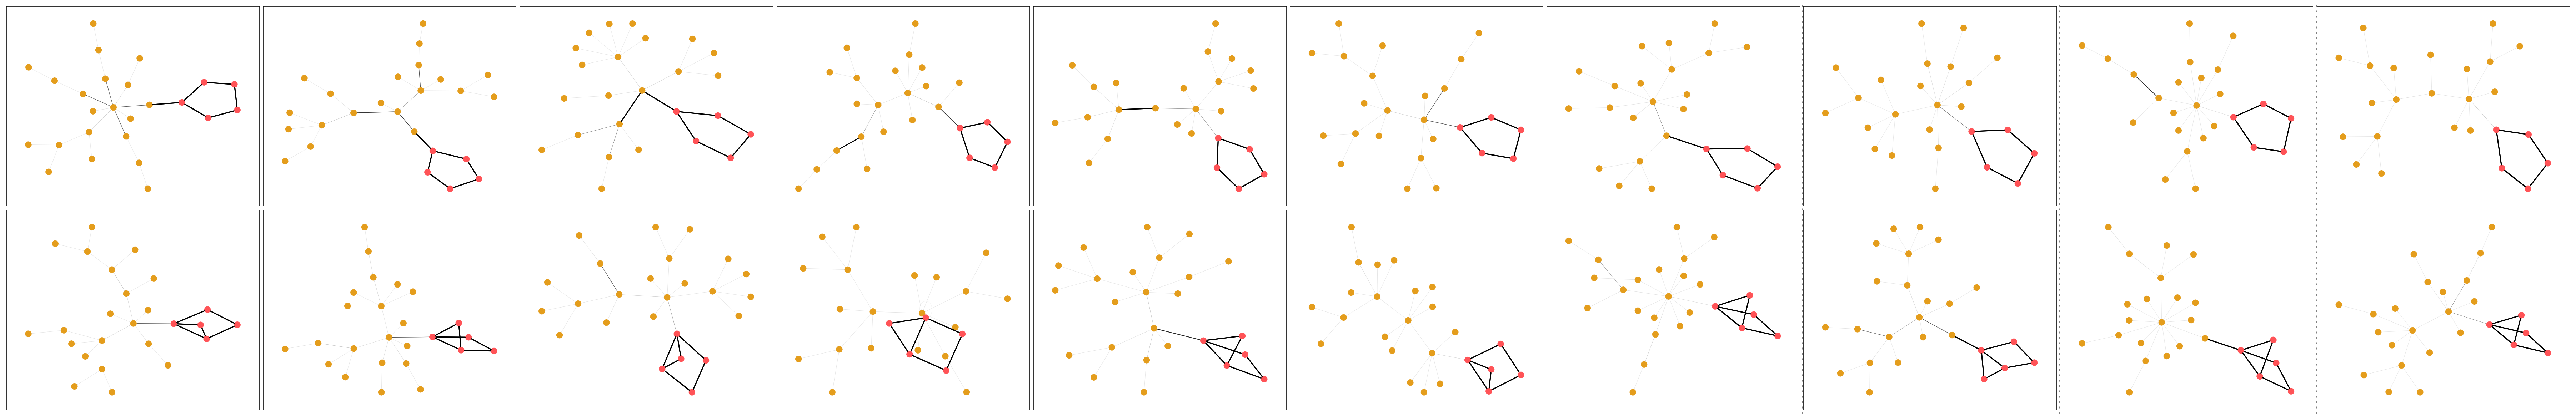

In [13]:
num_viz_samples = 10
assert aux_info['multi_label'] is False

all_viz_set = get_viz_idx(test_set, dataset_name, num_viz_samples)
visualize_results(gsat, all_viz_set, test_set, num_viz_samples, dataset_name, model_config['use_edge_attr'])